# PneumoCNN #3
###Usando redes neurais convolucionais para auxiliar diagnóstico da Pneumonia


### Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as ts

import keras
from keras.models import Sequential, model_from_json, load_model #manipulação de arquivos de armazenagem de rede
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def rearranjo():
    path = 'IC/chest_xray/chest_xray/'
    pastas = os.listdir("./"+ path)
    if not os.path.exists('chest_xray_v2'): os.mkdir('chest_xray_v2')
    if os.path.exists('./'+path+'.DS_Store'): os.remove('./'+path+'.DS_Store') # remocao de arquivo ambiente mac

    for i in range(len(pastas)):
        pasta = os.listdir('./IC/chest_xray/chest_xray/'+pastas[i]+'/PNEUMONIA')
        os.mkdir('chest_xray_v2/'+pastas[i])
        os.mkdir('chest_xray_v2/'+pastas[i]+'/VIRAL-PNEUMONIA')
        os.mkdir('chest_xray_v2/'+pastas[i]+'/BACTERIA-PNEUMONIA')
        os.mkdir('chest_xray_v2/'+pastas[i]+'/NORMAL')

        normal = os.listdir('./IC/chest_xray/chest_xray/'+pastas[i]+'/NORMAL')
        for j in range(len(normal)):

            pathfile = path + pastas[i] + "/NORMAL/" + normal[j]
            os.system('cp '+ pathfile + ' chest_xray_v2/'+ pastas[i]+ '/NORMAL')
            print(normal[j] + ' foi copiado para ' + "/chest_xray_v2/"+ pastas[i] + '/NORMAL')


        pneumo = os.listdir('./IC/chest_xray/chest_xray/'+pastas[i]+'/PNEUMONIA')
        for j in range(len(pneumo)):
            if 'virus' in pneumo[j]:
                pathfile = path + pastas[i] + "/PNEUMONIA/" + pneumo[j]
                os.system('cp '+ pathfile + ' chest_xray_v2/'+ pastas[i]+ '/VIRAL-PNEUMONIA')
                print(pneumo[j] + ' foi copiado para ' + "/chest_xray_v2"+ pastas[i] + '/VIRAL-PNEUMONIA')

            elif 'bacteria' in pneumo[j]:
                pathfile = path + pastas[i] + "/PNEUMONIA/" + pneumo[j]
                os.system('cp '+ pathfile + ' chest_xray_v2/'+ pastas[i]+ '/BACTERIA-PNEUMONIA')
                print(pneumo[j] + ' foi copiado para ' + "/chest_xray_v2/"+ pastas[i] + '/BACTERIA-PNEUMONIA')




A função rearranjo acima como o próprio nome sugere rearranja o dataset e subdivide o em três classes (Pneumonia bacteriana, pneunomia viral e normal).

In [ ]:
#rearranjo()

Após rearranjada uma vez, a chamada da função é comentada para evitar processamento desnecessário.

In [ ]:
path = "../chest_xray_v2/random/"
datagenerator_train = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   rotation_range = 5,
                                   zoom_range = 0.2, 
                                   width_shift_range=0.1,  
                                   height_shift_range=0.1,  
                                   horizontal_flip=True,  
                                   vertical_flip=True)  

training_set = datagenerator_train.flow_from_directory('../chest_xray_v2/train',
                                                 target_size = (150, 150),
                                                 batch_size = 20,
                                                 shuffle = True,
                                                 seed = 823,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 3 classes.


In [ ]:
datagenerator_val = ImageDataGenerator(rescale = 1./255) 
val_set = datagenerator_val.flow_from_directory('../chest_xray_v2/val',
                                            target_size = (150, 150),
                                            batch_size = 20,
                                            shuffle = True,
                                            seed = 823,
                                            class_mode = 'categorical')

Found 16 images belonging to 3 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale = 1./255)
test_set = datagen_test.flow_from_directory('../chest_xray_v2/test',
                                            target_size = (150, 150),
                                            batch_size = 20,
                                            shuffle = False,
                                            seed = 823,
                                            class_mode = 'categorical')

Found 624 images belonging to 3 classes.


In [ ]:
#Inicializando
cnn = Sequential(name = "CNN")

#1Camada Convolucional
cnn.add(Conv2D(name = "1st_camada_convolucional", filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
cnn.add(MaxPool2D(pool_size=2, strides=2))


#2Camada Convolucional
cnn.add(Conv2D(name = "2nd_camada_convolucional", filters = 64, kernel_size=4, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))


#3Camada Convolucional 
cnn.add(Conv2D(name = "3rd_camada_convolucional", filters = 128, kernel_size=3, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))

#Camada Flatten
cnn.add(Flatten())

#Fully Connected
cnn.add(Dense(units = 256, activation = 'relu'))
cnn.add(Dense(units = 3, activation = 'softmax'))


#Compilação
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

#Resumo
cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_camada_convolucional (Co (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
2nd_camada_convolucional (Co (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
3rd_camada_convolucional (Co (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0       

In [ ]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
cnntrained = cnn.fit(training_set,epochs = 100, steps_per_epoch = 10, validation_data = val_set, validation_steps = 20, callbacks=[checkpoint])
cnn.save('test2.h5')

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.3400WARNING:tensorflow:6 out of the last 8 calls to <function Model.make_test_function.<locals>.test_function at 0x7f9f86dce0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 00001: loss improved from inf to 1.29885, saving model to best_model.hdf5
10/10 [==============================] - 39s 4s/step - loss: 1.2989 - accu

Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6050
Epoch 00031: loss did not improve from 0.78034
10/10 [==============================] - 38s 4s/step - loss: 0.8688 - accuracy: 0.6050
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.5200
Epoch 00032: loss did not improve from 0.78034
10/10 [==============================] - 46s 5s/step - loss: 0.9577 - accuracy: 0.5200
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.5750
Epoch 00033: loss did not improve from 0.78034
10/10 [==============================] - 39s 4s/step - loss: 0.8716 - accuracy: 0.5750
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.8294 - accuracy: 0.6050
Epoch 00034: loss did not improve from 0.78034
10/10 [==============================] - 42s 4s/step - loss: 0.8294 - accuracy: 0.6050
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.8440 - a

Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.6750
Epoch 00066: loss did not improve from 0.68792
10/10 [==============================] - 31s 3s/step - loss: 0.6972 - accuracy: 0.6750
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.6950
Epoch 00067: loss improved from 0.68792 to 0.67407, saving model to best_model.hdf5
10/10 [==============================] - 36s 4s/step - loss: 0.6741 - accuracy: 0.6950
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7500
Epoch 00068: loss improved from 0.67407 to 0.61383, saving model to best_model.hdf5
10/10 [==============================] - 26s 3s/step - loss: 0.6138 - accuracy: 0.7500
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7000
Epoch 00069: loss did not improve from 0.61383
10/10 [==============================] - 25s 2s/step - loss: 0.7277 - accuracy: 0.7000
Epoch 

In [ ]:
cnn2 = load_model('NAOPERDEPELOAMORDEDEUS.h5')

In [ ]:
print('Acurácia: {:.2f}%'.format((cnn2.evaluate(test_set))[1]*100))

32/32 [==============================] - 50s 2s/step - loss: 0.8820 - accuracy: 0.7003
Acurácia: 70.03%


In [ ]:
label = (training_set.class_indices)
label = list(i for j,i in labels.items())
print(label)

['BACTERIA-PNEUMONIA', 'NORMAL', 'VIRAL-PNEUMONIA']


In [ ]:
test_set.reset()
predictions_test = np.argmax(cnn2.predict(test_set), axis=-1)

RELATÓRIO CLASSIFICAÇÃO 
                    precision    recall  f1-score   support

BACTERIA-PNEUMONIA       0.82      0.82      0.82       242
            NORMAL       0.94      0.50      0.66       234
   VIRAL-PNEUMONIA       0.47      0.81      0.59       148

          accuracy                           0.70       624
         macro avg       0.74      0.71      0.69       624
      weighted avg       0.78      0.70      0.71       624



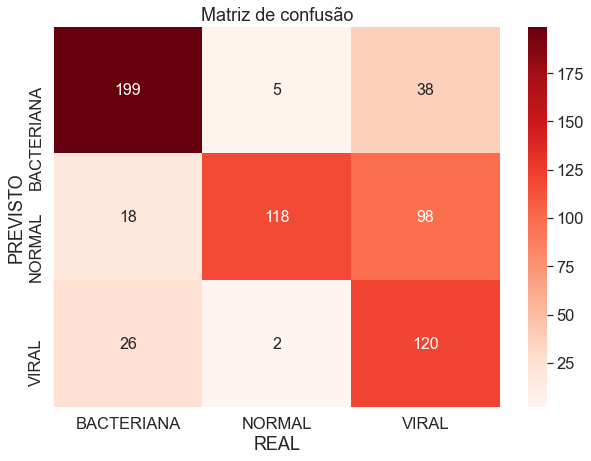

In [ ]:

y_true = np.array([0] * 242 + [1] * 234 + [2] * 148) #234 Normal, #242 Bacteriana #149 Viral
data = confusion_matrix(y_true, predictions_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'PREVISTO'
df_cm.columns.name = 'REAL'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.5)
ax = sns.heatmap(df_cm,cmap = 'Reds', annot=True,fmt = '.5g',annot_kws={"size": 16})
ax.set_title('Matriz de confusão')
ax.xaxis.set_ticklabels(['BACTERIANA', 'NORMAL', 'VIRAL']); ax.yaxis.set_ticklabels(['BACTERIANA', 'NORMAL', 'VIRAL']);
print("RELATÓRIO CLASSIFICAÇÃO ")
print(classification_report(y_true,predictions_test, target_names=label))

Text(0.5, 1.0, 'REAL: NORMAL')

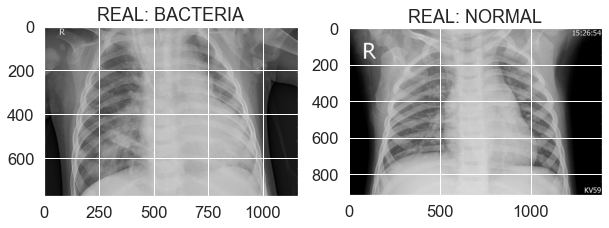

In [ ]:
import os, random
a = random.choice(os.listdir(path))
b = random.choice(os.listdir(path))

i=load_img(path+a)
j=load_img(path+b)
i=img_to_array(i)
i=np.array([i])
#print(cnn2.predict(i))
#print(i)
#print(cnn2.predict(path+b))

lst=[a,b]

for i in range(len(lst)):
    if 'virus' in lst[i]:
        lst[i] = (lst[i], "VIRUS")
    elif 'bacteria' in lst[i]:
        lst[i] = (lst[i], "BACTERIA")
    else:
        lst[i] = (lst[i], "NORMAL")

# Load the images
x = load_img(path+lst[0][0])
y = load_img(path+lst[1][0])

#Let's plt these images

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(x)
a1.set_title("REAL: " +lst[0][1])

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(y)
a2.set_title("REAL: " +lst[1][1])